In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.cosmology import FlatLambdaCDM
#from ligo.skymap.io.fits import read_sky_map
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
from healpy.newvisufunc import projview, newprojplot
#custom cmap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import glob
from astropy import units as u
from astropy.coordinates import SkyCoord

In [6]:
#Visualization of the GW and pixels with the highest probability
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('jet')
cmap = truncate_colormap(cmap, 0.24, 1)
tmp = cmap
newcolors = tmp(np.linspace(0, 1, 256))
white = np.array([1,1,1, 1])
newcolors[:2, :] = white
newcmp = ListedColormap(newcolors)
cmap = newcmp

In [7]:
arr = np.load("GW_skymaps.npy")
print(arr.shape)

(88,)


In [8]:
# Based on https://github.com/gw-odw/odw-2019/blob/master/Day_2/Tuto%202.6%20Working_with_gravitational_wave_skymaps.ipynb
prob = arr["probability"][8]
print(len(prob))
ipix_max = np.argmax(prob)
highest_probability = prob[ipix_max]
print(highest_probability)
print("The 10% of the highest probability for this event is:", 0.1*highest_probability)

786432
0.007644793951461124
The 10% of the highest probability for this event is: 0.0007644793951461124


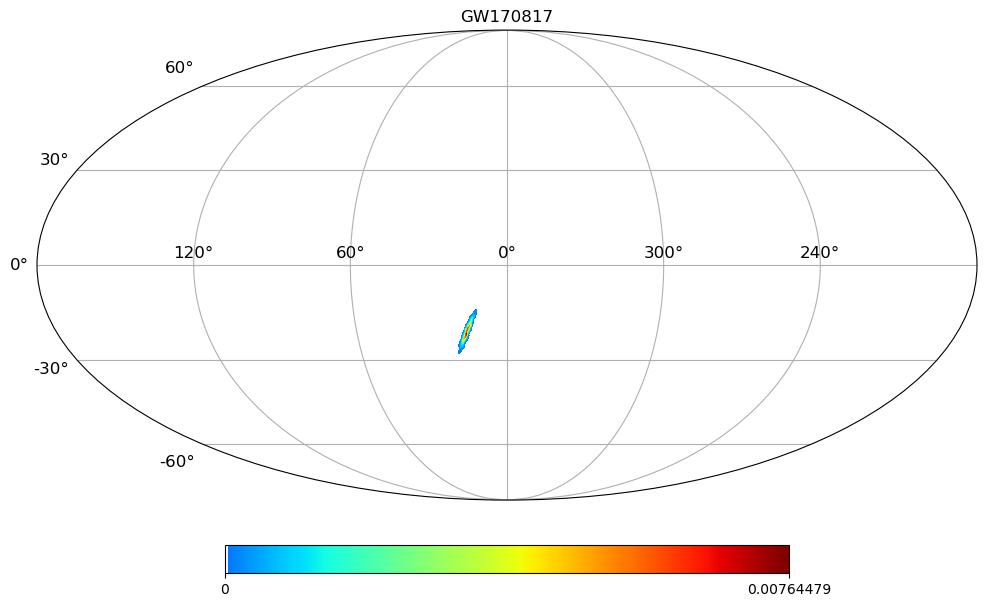

In [9]:
plt.figure(figsize=(10,10))
map=projview( arr["probability"][8],  rot = [180,0], graticule_labels=True, graticule=True, projection_type="mollweide",cmap=cmap,hold=True)
plt.title(arr["name"][8])
plt.show()

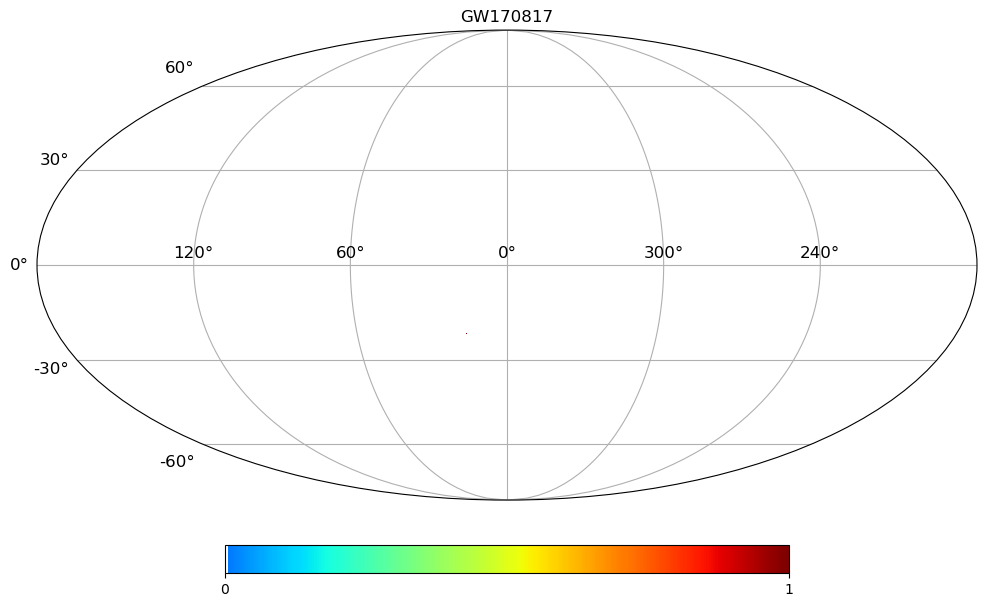

In [10]:
# Not super useful... Pixel with the highest probability
plt.figure(figsize=(10,10))
map=projview(arr["probability"][8]==np.max(arr["probability"][8]), rot = [180,0], graticule_labels=True, graticule=True, projection_type="mollweide",cmap=cmap,hold=True)
plt.title(arr["name"][8])
plt.show()

In [11]:
nside = hp.get_nside(prob) # calculate the healpix resolution - nside

In [12]:
theta, phi = hp.pix2ang(nside, ipix_max)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)

ra_highprob = round(ra,5); dec_highprob = round(dec,5);
print("The sky coordinates of the highest probability pixel are:", "ra =",ra_highprob,"dec =",dec_highprob, "(ICRS coordinates in degrees)")

The sky coordinates of the highest probability pixel are: ra = 196.34766 dec = -21.38194 (ICRS coordinates in degrees)


In [13]:
#Let's look for all the galaxies that could be the host of this event 
ind_prob_nonzero = np.where(prob > 0.0007)
ind_list = list(ind_prob_nonzero[0])
print(len(prob[ind_prob_nonzero]))

320


In [14]:
#Coordinates with prob > 10% highest probability for GW170817
ra_prob_nonzero = []
dec_prob_nonzero = []

for count, value in enumerate(ind_list):
    theta, phi = hp.pix2ang(nside,value)
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    ra_temp = round(ra,5); dec_temp = round(dec,5);
    ra_prob_nonzero.append(ra_temp)
    dec_prob_nonzero.append(dec_temp)

ra_prob_ar = np.array(ra_prob_nonzero)
dec_prob_ar = np.array(dec_prob_nonzero)

In [15]:
lum_d = arr["distmean"][8]
err_lum_d = arr["distvar"][8]

In [16]:
#Luminosity distance to z
cosmo = FlatLambdaCDM(H0=67.37, Om0=0.3147)
cosmo

FlatLambdaCDM(H0=67.37 km / (Mpc s), Om0=0.3147, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)

In [17]:
list_z = []
list_ld = []
for i in np.arange(0, 1, 0.0001):
    lum = cosmo.luminosity_distance(i)
    list_z.append(i)
    list_ld.append(lum.value)
print(np.min(list_z),np.max(list_z))

z_ar = np.array(list_z)
ld_ar = np.array(list_ld)

print(len(z_ar))

0.0 0.9999
10000


In [18]:
dl_to_z = np.array([ld_ar,z_ar]).T
dl_to_z[-1]

array([6.80589829e+03, 9.99900000e-01])

In [19]:
x0 = 38.03408225450563 #Mpc
y0 = np.interp(x0, ld_ar, z_ar)
print(y0)
cosmo.luminosity_distance(y0)

0.008492176429540846


<Quantity 38.03407983 Mpc>

In [20]:
# Now, let's find the galaxies in 2MPP that are inside that patch of the sky
# 2MPP catalog (Lavaux & Hutson 2011)
gal_2mpp = ascii.read("/Users/lgarcia/LSS-GW/2MPP.txt")
ra_2mpp = np.degrees(gal_2mpp["col2"]).data
dec_2mpp = np.degrees(gal_2mpp["col3"]).data
z_2mpp = gal_2mpp["col4"].data
ap_mag_2mpp = gal_2mpp["col5"].data
abs_mag_2mpp = gal_2mpp["col6"].data

In [21]:
# Limits of right ascension and declination coordinates 
print(round(np.min(ra_2mpp),5),round(np.max(ra_2mpp),5))
print(round(np.min(dec_2mpp),5),round(np.max(dec_2mpp),5))
print(len(gal_2mpp["col2"]))

0.00344 359.98022
-89.33443 89.09322
67224


In [23]:
# Let's do a consistency test:

# NGC4993:
# Coordinates host galaxy of this GW event (electromagnetically confirmed): NGC4993 -see Coulter et al. 2017-
# https://docs.astropy.org/en/stable/coordinates/index.html
# https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html
c = SkyCoord('13h09m47.7s', '-23d23m2.2s', frame='icrs')
c.ra,c.dec

(<Longitude 197.44875 deg>, <Latitude -23.38394444 deg>)

In [24]:
print("The estimated z for GW170817 is:",round(y0,6))
cosmo.luminosity_distance(y0)

The estimated z for GW170817 is: 0.008492


<Quantity 38.03407983 Mpc>

In [25]:
for i in range(len(gal_2mpp["col2"])):
    if((ra_2mpp[i] >= 197.0) & (ra_2mpp[i] < 198)).any():
        if ((dec_2mpp[i] >= -24.0) & (dec_2mpp[i] <= -23.0)):
            print(ra_2mpp[i],dec_2mpp[i],z_2mpp[i])
#0.01015397

197.77815538561862 -23.86747368864665 0.0334683
197.69163875855386 -23.86575481526126 0.0106041
197.01784039148 -23.79682799250702 0.01098
197.4487046534184 -23.383840013776723 0.0107259


In [27]:
print(lum_d,err_lum_d)

38.03408225450563 7.499686641911211


In [36]:
# Errors in the calculated z based on \Delta L (err_lum_d):
fac = 2
lum_d_low = lum_d - fac*err_lum_d
lum_d_upp = lum_d + fac*err_lum_d
print(lum_d_low,lum_d,lum_d_upp) #Mpc

23.034708970683205 38.03408225450563 53.03345553832805


In [37]:
z_low = np.interp(lum_d_low, ld_ar, z_ar)
z_upp = np.interp(lum_d_upp, ld_ar, z_ar)
print(z_low,z_upp)
#print(cosmo.luminosity_distance(z_low),cosmo.luminosity_distance(z_upp))

0.005156134823909508 0.011811668318615682


In [38]:
z_err_low = y0 - z_low
z_err_upp = y0 + z_upp
print("z_GW:",y0,"+:",z_err_upp,"-:",z_err_low)

z_GW: 0.008492176429540846 +: 0.020303844748156528 -: 0.003336041605631338


In [41]:
ra_2mpp_reg = []
dec_2mpp_reg = []
ID_2mpp_reg = []
z_2mpp_reg = []

for i in range(len(gal_2mpp["col2"])):
    if(ra_2mpp[i] >= np.min(ra_prob_ar)) & (ra_2mpp[i] <= np.max(ra_prob_ar)):
        if (dec_2mpp[i] >= np.min(dec_prob_ar)) & (dec_2mpp[i] <= np.max(dec_prob_ar)):
            ID_2mpp_reg.append(i)
            ra_2mpp_reg.append(ra_2mpp[i])
            dec_2mpp_reg.append(dec_2mpp[i])
            z_2mpp_reg.append(z_2mpp[i])
            
ra_arr_0 = np.array(ra_2mpp_reg)
dec_arr_0 = np.array(dec_2mpp_reg)

print(ra_arr_0.shape)
            
# Optional:           
#np.savetxt('possible_gal_candidates_GW170817.txt', np.array([ID_2mpp_reg,ra_2mpp_reg,dec_2mpp_reg,z_2mpp_reg]).T, delimiter='\t', fmt="%s") 

(318,)


In [43]:
ra_2mpp_reg = []
dec_2mpp_reg = []
ID_2mpp_reg = []
z_2mpp_reg = []
app_mag_reg = []

for i in range(len(gal_2mpp["col2"])):
    if(ra_2mpp[i] >= np.min(ra_prob_ar)) & (ra_2mpp[i] <= np.max(ra_prob_ar)):
        if (dec_2mpp[i] >= np.min(dec_prob_ar)) & (dec_2mpp[i] <= np.max(dec_prob_ar)):
            if (z_2mpp[i] >= z_low) & (z_2mpp[i] <= z_upp):
                ID_2mpp_reg.append(i)
                ra_2mpp_reg.append(ra_2mpp[i])
                dec_2mpp_reg.append(dec_2mpp[i])
                z_2mpp_reg.append(z_2mpp[i])
                app_mag_reg.append(ap_mag_2mpp[i])
            
ra_arr_1 = np.array(ra_2mpp_reg)
dec_arr_1 = np.array(dec_2mpp_reg)

print(ra_arr_1.shape)
            
# Optional:           
np.savetxt('possible_gal_candidates_GW170817.txt', np.array([ID_2mpp_reg,ra_2mpp_reg,dec_2mpp_reg,z_2mpp_reg,app_mag_reg]).T, delimiter='\t', fmt="%s") 

(36,)


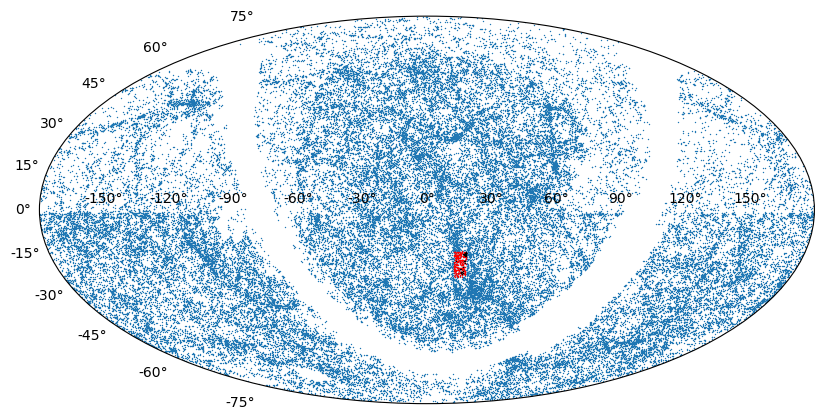

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(gal_2mpp["col2"]-np.pi,gal_2mpp["col3"],lw=0,s=1)
ax.scatter(np.deg2rad(ra_arr_0)-np.pi,np.deg2rad(dec_arr_0),lw=0,c='red',s=1)
ax.scatter(np.deg2rad(ra_arr_1)-np.pi,np.deg2rad(dec_arr_1),lw=0,c='black',s=1)

In [4]:
# https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=ngc+4993&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES
app_mag_4993 = 13.32 

# But
print("The min and max apparent magnitudes in 2MPP are:",np.min(ap_mag_2mpp),np.max(ap_mag_2mpp))
print("Likewise, the min and max absolute magnitudes in 2MPP are:",np.min(abs_mag_2mpp),np.max(abs_mag_2mpp))

The min and max apparent magnitudes in 2MPP are: 4.09313 12.5
Likewise, the min and max absolute magnitudes in 2MPP are: -26.7656 -13.1995


In [ ]:
# Use the absolute (fifth column) and apparent magnitude (4th column) to shrink the number of galaxies in the sample ???